## CutMix, Mixup exp
- 초기 실험 중요
  - 얼마나 걸리는지.. 등..을 확인 후에, **자원을 효율적으로 사용**하기 위하여 초기 실험의 환경을 설정해야 함
  - 뭘 먼저 확인할 건지 우선 순위 설정도 해야 함
- 오버피팅 지점이 어디..? -> 각 모델의 오버피팅을 확인해야함
- 테스트 데이터를 이용해서 진짜 잘 나오는지 확인
  - 오버피팅 전 && 최적화 모델
- 중간 중간 기록하기
- Training loss와 validation accuracy 비교
- 그래프를 세로로 놓으면 에폭을 비교하기 편함

### 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### **Cutmix Augmentation**

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [6]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **Mixup Augmentation**

In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **augmentations을 적용하는 함수**

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

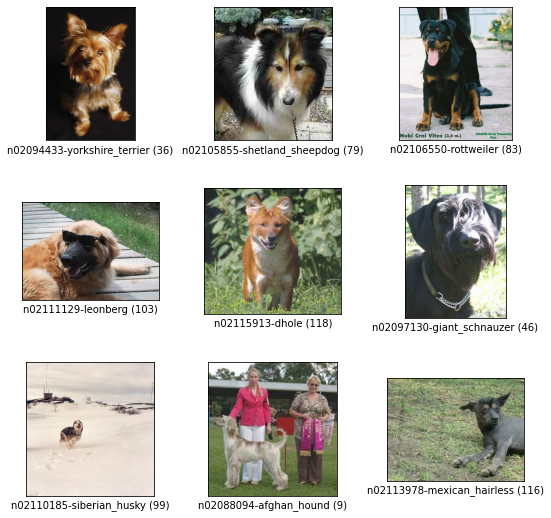

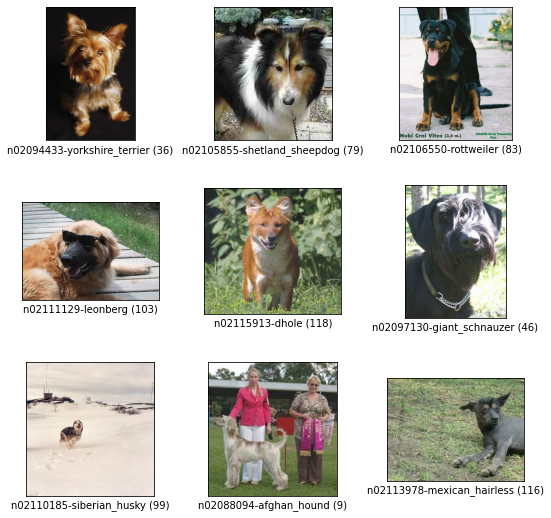

In [13]:
tfds.show_examples(ds_train, ds_info)

In [14]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

In [15]:
num_classes = ds_info.features["label"].num_classes

In [16]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 2. 모델 만들기

In [17]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 3. 모델 훈련하기
- categorical_crossentropy() 손실 함수 사용

#### 3.1 초기 실험
- Augmentation하지 않은 데이터 셋
- ResNet-50
- 충분히 학습해서 overfitting 시킬 것
----
- 한 epoch에 대략 2:30정도..
- 6번째 epoch부터 벌써 validation loss가 개선되지 않음 -> 일단 15 epochs까지만 돌리고 찍어보자..

In [21]:
EPOCH_OVR = 15

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path_no_aug = os.getenv('HOME')+'/aiffel/data_augmentation/no_aug_checkpoint.weights.h5'
model_checkpoint_no_aug = ModelCheckpoint(
    checkpoint_path_no_aug,
    save_weights_only=True, 
    monitor='val_loss',
    save_best_only=True,
    verbose=1)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH_OVR,
    callbacks=[model_checkpoint_no_aug],
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 173s 205ms/step - loss: 2.1978 - accuracy: 0.4500 - val_loss: 2.9365 - val_accuracy: 0.2678

Epoch 00001: val_loss improved from inf to 2.93646, saving model to /aiffel/aiffel/data_augmentation/no_aug_checkpoint.weights.h5
Epoch 2/15
750/750 [==============================] - 153s 204ms/step - loss: 0.7633 - accuracy: 0.7882 - val_loss: 1.0917 - val_accuracy: 0.6791

Epoch 00002: val_loss improved from 2.93646 to 1.09166, saving model to /aiffel/aiffel/data_augmentation/no_aug_checkpoint.weights.h5
Epoch 3/15
750/750 [==============================] - 153s 204ms/step - loss: 0.2462 - accuracy: 0.9469 - val_loss: 0.9805 - val_accuracy: 0.7137

Epoch 00003: val_loss improved from 1.09166 to 0.98054, saving model to /aiffel/aiffel/data_augmentation/no_aug_checkpoint.weights.h5
Epoch 4/15
750/750 [==============================] - 153s 204ms/step - loss: 0.1120 - accuracy: 0.9851 - val_loss: 0.9858 - val_accuracy: 0.7207

Epoch 00004: v

### 4. 훈련 과정 시각화하기
- 히스토리를 그래프로 시각화

In [22]:
def visualize_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

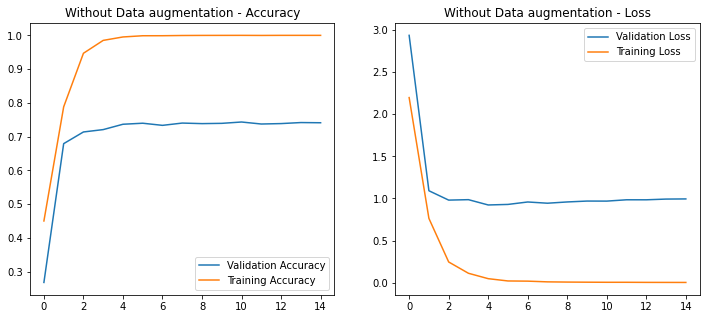

In [23]:
visualize_history(history_resnet50_no_aug, "Without Data augmentation")

#### 4.1 초기 실험 결과 분석
- Training accuracy가 거의 1에 수렴
- Training loss 역시 0에 수렴
  -  Overfitting 패턴
- Validation accuracy는 특정 구간에서 정체
- Validation loss는 살짝 올라가는 것 같으나, 심하지 않음
  - Overfitting 패턴은 맞지만, validation loss 가 많이 증가하지는 않음
----
**결론**  
- Overfitting은 맞는 것 같은데, 데이터 셋 자체가 적고 학습 데이터랑 검증 데이터랑 비슷한 분포를 가지고 있는 듯..

c.f.  
![graph](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-2-P-result01.png)
![graph](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-2-P-result02.png)